In [1]:
import os
#os.chdir("D:\\Study\\financial")
os.chdir(r"C:\workspace\python\PriceCompare\temp\2017s02\pdf")

In [2]:
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTTextBox, LTTextLine, LTRect, LTChar

In [24]:
# 检测一维坐标轴上两个线段是否有重合 (重合长度小于1不算)
def test_overlap(lower_bound, upper_bound, f_small, f_big):
    iMinOvl = 1
    if f_big <= lower_bound + iMinOvl or f_small >= upper_bound - iMinOvl:
        return False
    return True
#end def

In [3]:
def group_by_line(lsTextArea):
    dGrp = {}
    iGrp = 0
    for dText in lsTextArea:
        x0, y0, x1, y1 = dText['bbox']
        bFound = False
        for iKey, dVal in dGrp.items():
            tRng = dVal['range']
            if test_overlap(tRng[0], tRng[1], y0, y1):
                dVal['list'].append(dText)
                dVal['range'] = (min(tRng[0], y0), max(tRng[1], y1))
                bFound = True
                break
        #end for
        if not bFound:
            dVal = {}
            dVal['range'] = (y0, y1)
            dVal['list'] = [dText]
            iGrp += 1
            dGrp[iGrp] = dVal
    #end for
    #print("We got {} groups".format(len(dGrp)))
    
    for dVal in dGrp.values():
        dVal['list'] = sorted(dVal['list'], key = lambda d: d['bbox'][0])
    
    lsLines = sorted(dGrp.values(), key = lambda d: d['range'][0], reverse=True)
    
    #for dVal in lsLines:
    #    print('\t'.join([bx['text'].strip().replace('\n', '') for bx in dVal['list']]))
    
    return lsLines
            

In [4]:
# Initialization

# Open a PDF file.
fp = open('160223.pdf', 'rb')

# Create a PDF parser object associated with the file object.
parser = PDFParser(fp)
doc = PDFDocument()
parser.set_document(doc)
doc.set_parser(parser)
doc.initialize('')
fp.close()

rsrcmgr = PDFResourceManager()
laparams = LAParams()
device = PDFPageAggregator(rsrcmgr, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)


In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
# Go to specific page
i = 0
for page in doc.get_pages():
    i += 1
    if i == 11:
        interpreter.process_page(page)
        layout = device.get_result()
        break


In [ ]:
# Find very close points in a given set
def getPtEntry(dAllPt, tOnePt):
    for tPt in dAllPt:
        if tOnePt[0] > tPt[0] - 1 and tOnePt[0] < tPt[0] + 1 and tOnePt[1] > tPt[1] - 1 and tOnePt[1] < tPt[1] + 1:
            return tPt
        if tOnePt[0] > tPt[0] - 1 and tOnePt[0] < tPt[0] + 1:
            tOnePt = (tPt[0], tOnePt[1])
        if tOnePt[1] > tPt[1] - 1 and tOnePt[1] < tPt[1] + 1:
            tOnePt = (tOnePt[0], tPt[1])
    #end for
    # Did not find entry, create one
    dAllPt[tOnePt] = set()
    return tOnePt
#end def

In [18]:
# 新增交点信息 (not used)
def addCornerInfo(dCorners, tLine):
    x0, y0, x1, y1 = tLine
    
    if (x0, y0) not in dCorners:
        dCorners[(x0, y0)] = {}
    if (x1, y1) not in dCorners:
        dCorners[(x1, y1)] = {}
    
    if x0 == x1:    # 垂直线
        dCorners[(x0, y0)]['u'] = (x1, y1)  # up
        dCorners[(x1, y1)]['d'] = (x0, y0)  # down
    else:           # 水平线
        dCorners[(x0, y0)]['r'] = (x1, y1)  # right
        dCorners[(x1, y1)]['l'] = (x0, y0)  # left
    
#end def

In [13]:
# Get standardised point. 尽量获取最相近的x坐标和y坐标，如果找不到相近的，那就创建一个新的
def getStdPoint(lsX, lsY, tPt):
    x, y = tPt
    
    bFound = False
    for xi in lsX:
        # 如果误差在 1 内，则认为是相近的点
        if x > xi - 1 and x < xi + 1:
            x = xi
            bFound = True
            break
    if not bFound:
        lsX.append(x)
        
    bFound = False
    for yi in lsY:
        if y > yi - 1 and y < yi + 1:
            y = yi
            bFound = True
            break
    if not bFound:
        lsY.append(y)
    
    return (x, y)
#end def

In [7]:
# Find a nearby number in a list. 如果找不到相近的，那就增加一个新的到列表中去
def getNearbyNumber(lsX, x):
    for xi in lsX:
        # 如果误差在 1 内，则认为是相近的点
        if x > xi - 1 and x < xi + 1:
            return xi

    # 如果找不到相近的，那就增加一个新的到列表中去
    lsX.append(x)    
    return x
#end def

In [8]:
# 把(标准化后的)竖线加到相应的 x 坐标组去 (或把横线加到相应的 y 坐标组中去)
def addStdLineToGroup(dX, x, y0, y1):
    if x in dX:
        dX[x].append( (y0, y1) )
    else:
        dX[x] = [ (y0, y1) ]
#end def



In [11]:
# 新增交点信息 (not used)
def addCornerInfo(dCornerInfo, tPoint, stCrosses):
    if tPoint in dCornerInfo:
        dCornerInfo[tPoint].update(stCrosses)
    else:
        dCornerInfo[tPoint] = stCrosses
#end def

# 把交点 x 坐标加入到按 y 坐标分类的字典中 (或 把交点 y 坐标 加入到按 x 坐标分类的字典中)
def addCorner(dH, y, x):
    if y in dH:
        dH[y].add(x)
    else:
        dH[y] = {x}
#end def


In [9]:
# 生成 按照 x 坐标分类的 横线, 以及 按照 y 坐标分类的 竖线
i = 0
dX = {}    # 按照 x 坐标分类的 横线
dY = {}    # 按照 y 坐标分类的 竖线
lsX = []    # 所有可能的x坐标
lsY = []
#lsVLines = []
#lsHLines = []
#lsRects = []
#dCorners = {}
for lt_obj in layout:
    #print(type(lt_obj))
    if isinstance(lt_obj, LTRect):
        if lt_obj.width < 1 and lt_obj.height < 1:
            continue
        i += 1
        #print(lt_obj.width, lt_obj.height)
        #x0 = getNearbyNumber(lsX, lt_obj.x0)
        #y0 = getNearbyNumber(lsY, lt_obj.y0)
        if lt_obj.width < 1:      # vertical line 竖线
            #y1 = getNearbyNumber(lsY, lt_obj.y1)
            #lsVLines.append( (x0, y0, x0, y1) )
            #addCornerInfo(dCorners, (x0, y0, x0, y1))
            addStdLineToGroup( dX, getNearbyNumber(lsX, lt_obj.x0), getNearbyNumber(lsY, lt_obj.y0), getNearbyNumber(lsY, lt_obj.y1) )
        elif lt_obj.height < 1:   # horizontal line
            #x1 = getNearbyNumber(lsX, lt_obj.x1)
            #lsHLines.append( (x0, y0, x1, y0) )
            #addCornerInfo(dCorners, (x0, y0, x1, y0))
            addStdLineToGroup( dY, getNearbyNumber(lsY, lt_obj.y0), getNearbyNumber(lsX, lt_obj.x0), getNearbyNumber(lsX, lt_obj.x1) )
        else:
            #x1 = getNearbyNumber(lsX, lt_obj.x1)
            #y1 = getNearbyNumber(lsY, lt_obj.y1)
            #lsRects.append( (x0, y0, x1, y1) )
            pass
#end for


In [12]:
# 找到所有的交点
dCornerInfo = {}  # 交点的相交信息
dHCorners = {}    # 按横线（y坐标）归类的交点
dVCorners = {}    # 按竖线（x坐标）归类的交点
# 遍历所有横线
for y, lsH in dY.items():
    for x0, x1 in lsH:
        # 遍历所有竖线
        for x, lsV in dX.items():
            if (x < x0) or (x > x1):
                if x > x0-1 and x < x1 + 1:
                    print(x, x0, x1)
                continue    # 如果竖线的 x 坐标不在横线范围内，则不可能相交
            for y0, y1 in lsV:
                if (y < y0) or (y > y1):
                    continue    # 如果横线的 y 坐标不在竖线范围内，则不可能相交
                
                stCrosses = set()
                
                if y < y1:
                    stCrosses.add('u')
                if y > y0:
                    stCrosses.add('d')
                if x < x1:
                    stCrosses.add('r')
                if x > x0:
                    stCrosses.add('l')
                
                addCornerInfo(dCornerInfo, (x, y), stCrosses)
                addCorner(dHCorners, y, x)
                addCorner(dVCorners, x, y)
                
#end for

# 给按横（纵）坐标归类的交点进行组内排序
for y in dHCorners:
    dHCorners[y] = sorted(dHCorners[y])
for x in dVCorners:
    dVCorners[x] = sorted(dVCorners[x])

In [13]:
# 生成所有矩形列表
lsRects = []
for tPoint, stCrosses in dCornerInfo.items():
    # 从左下角开始形成矩形
    if ('u' in stCrosses) and ('r' in stCrosses):
        x0, y0 = tPoint
        # 先往右找到右下角顶点
        lsH = dHCorners[y0]
        bFound = False
        for i in range(lsH.index(x0)+1, len(lsH)):
            x1 = lsH[i]
            stCrs = dCornerInfo[(x1, y0)]
            if 'l' not in stCrs:
                break    # 横线中间有断裂
            if ('l' in stCrs) and ('u' in stCrs):
                bFound = True
                break
        if bFound:    # 找到了右下角的顶点
            # 接着往上找右上角顶点
            lsV = dVCorners[x1]
            bFound = False
            for i in range(lsV.index(y0)+1, len(lsV)):
                y1 = lsV[i]
                stCrs = dCornerInfo[(x1, y1)]
                if 'd' not in stCrs:
                    break    # 竖线中间有断裂
                if ('d' in stCrs) and ('l' in stCrs):
                    bFound = True
                    break
        if bFound:    # 找到了右上角的顶点
            lsRects.append( (x0, y0, x1, y1) )
#end for


In [14]:
# 生成文本 位置-内容对 dTxt[(x0, y0, x1, y1)] = sText
i = 0
dTxt = {}
for lt_obj in layout:
    if isinstance(lt_obj, LTTextBox):
        i += 1
        for xx in lt_obj:
            if isinstance(xx, LTTextLine):
                dTxt[xx.bbox] = xx.get_text().rstrip('\n')   # 勿使用 strip(), 因为前后的空格有占位的作用

In [16]:
# 计算 重合区域面积
def getOverlapArea(r1, r2):
    x1, y1, x2, y2 = r1
    a1, b1, a2, b2 = r2
    if (x2<a1 or a2<x1 or y2<b1 or b2<y1):
        return 0
    
    l = max(x1, a1)   # left
    b = max(y1, b1)   # bottom
    r = min(x2, a2)   # right
    t = min(y2, b2)   # top
    
    return (r-l) * (t-b)
#end def

# 返回 重合区域 在 r1、r2 的百分比位置
def getOverlapPctPos(r1, r2):
    x1, y1, x2, y2 = r1
    a1, b1, a2, b2 = r2
    if (x2<a1 or a2<x1 or y2<b1 or b2<y1):
        return None
    
    l = max(x1, a1)   # left
    b = max(y1, b1)   # bottom
    r = min(x2, a2)   # right
    t = min(y2, b2)   # top
    
    w1 = x2 - x1    # width of r1
    h2 = b2 - b1    # height of r2
    
    l = (l - x1) / w1  # percentage position of left line in r1
    r = (r - x1) / w1
    b = (b - b1) / h2  # percentage position of bottom line in r2
    t = (t - b1) / h2
    
    return (l, r, b, t)
#end def

In [18]:
# 找到字符串中离指定位置最近的空格字符
def findNearSpaceIndex(s, fRatio):
    nLen = len(s)
    i = round(nLen * fRatio)
    if i >= nLen or i <= 0:
        return i
    if s[i] == ' ':
        return i
    # i1 往左搜寻, i2 往右搜寻
    i1 = i - 1
    i2 = i + 1
    while i1 >= 0 or i2 < nLen:
        if i1 >= 0:
            if s[i1] == ' ':
                return i1
            i1 -= 1
        if i2 <= nLen - 1:
            if s[i2] == ' ':
                return i2
            i2 += 1
    #end while
    return i
#end def

In [19]:
# 根据文本所在单元格重新设置文本的位置
dModTxt = {}
for r1, sTxt in dTxt.items():
    bFound = False
    for r2 in lsRects:
        '''
        fOvlArea = getOverlapArea(r1, r2)
        if fOvlArea > 0:
            fTxtArea = (r1[2] - r1[0]) * (r1[3] - r1[1])
            fOvlPctg = fOvlArea/fTxtArea
            print('"{}" is {:.2%} overlapped with area {}'.format(sTxt, fOvlArea/fTxtArea, r2))
        '''
        tOvlPos = getOverlapPctPos(r1, r2)
        if tOvlPos:    # 能找到有重合部分的表格单元格
            bFound = True
            l, r, b, t = tOvlPos
            #nLen = len(sTxt)
            #il = round(nLen * l)
            #ir = round(nLen * r)
            il = findNearSpaceIndex(sTxt, l)
            ir = findNearSpaceIndex(sTxt, r)
            #print('"{}" is {:.2%} overlapped with area {}\n\t\t\t{}'.format(sTxt, min(r-l, t-b), r2, sTxt[il:ir].strip()))
            tInf = (b, sTxt[il:ir].strip())   # b: 垂直位置
            if r2 in dModTxt:
                dModTxt[r2].append( tInf )
            else:
                dModTxt[r2] = [ tInf ]
    #end for
    
    if not bFound:    # 找不到相交的单元格，即，文本不属于表格
        dModTxt[r1] = sTxt
        #pass
#end for

In [20]:
# 合并处于同一单元格的文本
for r, v in dModTxt.items():
    if type(v) is list:
        slTp = sorted(v, key = lambda x: x[0], reverse = True)
        sConcat = ''.join(x[1] for x in slTp)
        dModTxt[r] = sConcat

In [25]:
# 按从左至右、从上至下的方式排列文本
def sortTexts(dTxt):
    dGrp = {}    # { i: {'range': (y0, y1), 'list': [(r, sTxt), ...]} }
    iGrp = 0
    for tInf in dTxt.items():
        r, sTxt = tInf
        x0, y0, x1, y1 = r
        bFound = False
        # 找到所属行
        for iKey, dVal in dGrp.items():
            tRng = dVal['range']
            if test_overlap(tRng[0], tRng[1], y0, y1):
                dVal['list'].append(tInf)
                dVal['range'] = (min(tRng[0], y0), max(tRng[1], y1))
                bFound = True
                break
        #end for
        if not bFound:
            dVal = {}
            dVal['range'] = (y0, y1)
            dVal['list'] = [tInf]
            iGrp += 1
            dGrp[iGrp] = dVal
    #end for
    
    # 每行行内从左到右排列
    for dVal in dGrp.values():
        dVal['list'] = sorted(dVal['list'], key = lambda t: t[0][0])
    
    # 所有行从上到下排列
    lsLines = sorted(dGrp.values(), key = lambda d: d['range'][0], reverse=True)
    
    return lsLines
#end def

In [27]:
lsLines = sortTexts(dModTxt)
for dLine in lsLines:
    lsCols = dLine['list']
    print('\t'.join(t[1] for t in lsCols)) 

国泰创业板指数证券投资基金（LOF）2017 年第 2 季度报告 
O	居民服务、修理和其他服务业	-	-
P	教育	-	-
Q	卫生和社会工作	-	-
R	文化、体育和娱乐业	-	-
S	综合	-	-
合计	3,161,633.00	4.35
5.2.2指数投资按行业分类的股票投资组合 
代码	行业类别	公允价值（元）	占基金资产净值比例（％）
A	农、林、牧、渔业	5,560,085.20	7.66
B	采矿业	-	-
C	制造业	30,280,332.11	41.70
D	电力、热力、燃气及水生产和供应业	-	-
E	建筑业	1,428,152.80	1.97
F	批发和零售业	-	-
G	交通运输、仓储和邮政业	-	-
H	住宿和餐饮业	-	-
I	信息传输、软件和信息技术服务业	18,491,378.84	25.47
J	金融业	-	-
K	房地产业	-	-
L	租赁和商务服务业	711,025.68	0.98
M	科学研究和技术服务业	-	-
N	水利、环境和公共设施管理业	2,918,130.14	4.02
O	居民服务、修理和其他服务业	-	-
P	教育	-	-
Q	卫生和社会工作	1,851,894.86	2.55
R	文化、体育和娱乐业	3,044,306.87	4.19
S	综合	-	-
	合计	64,285,306.50	88.54
5.3报告期末按公允价值占基金资产净值比例大小排序的股票投资明细 
5.3.1 期末指数投资按公允价值占基金资产净值比例大小排序的前十名股票投
资明细 
11 


<IPython.core.display.Javascript object>


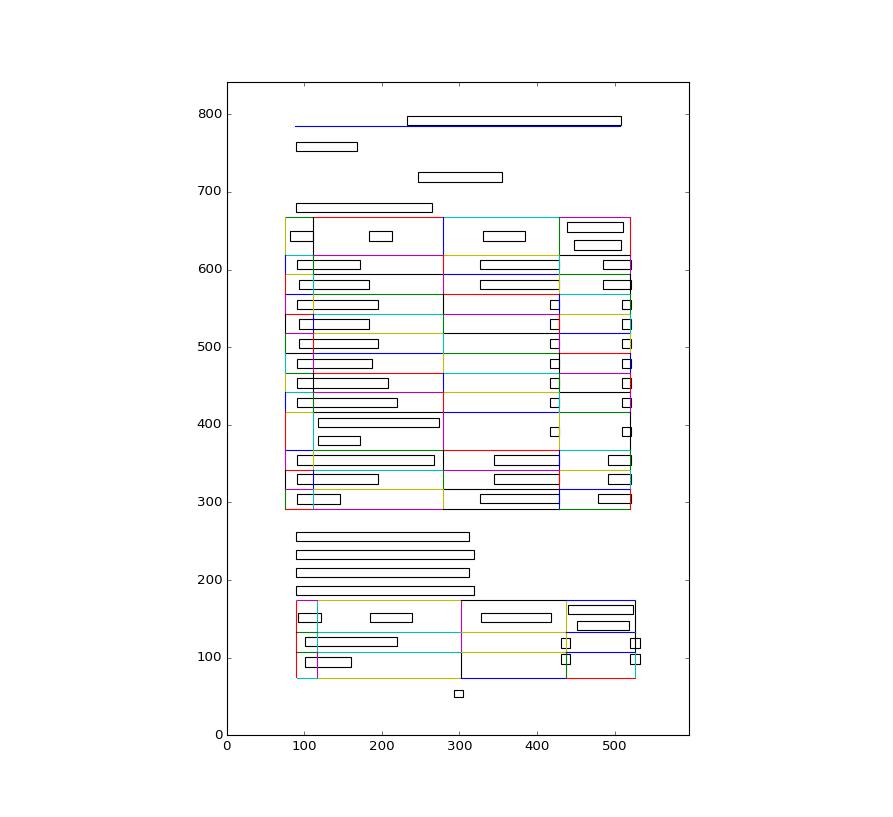


Total specified objects: 227


In [186]:
# 画出某页面的结构图

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')  # 111: nrows, ncols, plot_number
ax1.set_xlim(layout.x0, layout.x1)
ax1.set_ylim(layout.y0, layout.y1)
  

i = 0
lsTxtArea = []
for lt_obj in layout:
    #print(type(lt_obj))
    if isinstance(lt_obj, LTRect):
        if lt_obj.width < 1 and lt_obj.height < 1:
            continue
        i += 1
        #print(lt_obj.width, lt_obj.height)
        if lt_obj.width < 1:
            #print(lt_obj.x0, lt_obj.y0, lt_obj.y1)
            #ax1.axvline(lt_obj.x0, ymin=lt_obj.y0, ymax=lt_obj.y1, linewidth = 5, color='darkviolet')
            plt.plot((lt_obj.x0, lt_obj.x0), (lt_obj.y0, lt_obj.y1))
        elif lt_obj.height < 1:
            #print(lt_obj.y0, lt_obj.x0, lt_obj.x1)
            #ax1.axhline(lt_obj.y0, xmin=lt_obj.x0, xmax=lt_obj.x1, linewidth = 5, color='g')
            plt.plot((lt_obj.x0, lt_obj.x1), (lt_obj.y0, lt_obj.y0))
        else:
            print(lt_obj.x0, lt_obj.y0, lt_obj.width, lt_obj.height)
            ax1.add_patch(
                patches.Rectangle(
                    (lt_obj.x0, lt_obj.y0),   # (x,y)
                    lt_obj.width,          # width
                    lt_obj.height,          # height
                    fill=False      # no background
                )
            )
    #continue
    if isinstance(lt_obj, LTTextBox):
        #if lt_obj.width < 5 or lt_obj.height < 5:
        #    continue
        i += 1
        #print("{}: {}".format(i, lt_obj.bbox))
        
        #for aa in lt_obj:
        #    #print(type(aa))
        #    for bb in aa:
        #        if not isinstance(bb, LTChar):
        #            print(type(bb))
                
        #lsTxtBox.append(lt_obj)
        
        bFill = False
        #if '300104' in lt_obj.get_text():
        #if True:
            #bFill = True
        #print(type(lt_obj))
        #print(lt_obj.get_text())
        for xx in lt_obj:
            #print(xx.get_text())
            #print(type(xx), isinstance(xx, LTTextLine))
            if isinstance(xx, LTTextLine):
                lsTxtArea.append({'text': xx.get_text(), 'bbox': xx.bbox})
                ax1.add_patch(
                    patches.Rectangle(
                        (xx.x0, xx.y0),   # (x,y)
                        xx.width,          # width
                        xx.height,          # height
                        fill=bFill      # no background
                    )
                )
                
                #for yy in xx:
                #    if isinstance(yy, LTTextLine):
                #        print(yy.get_text())
                
        '''
        ax1.add_patch(
            patches.Rectangle(
                (lt_obj.x0, lt_obj.y0),   # (x,y)
                lt_obj.width,          # width
                lt_obj.height,          # height
                fill=bFill      # no background
            )
        )
        '''
        #if i > 300:
        #    break
        #print(lt_obj.get_text())
print("\nTotal specified objects: {}".format(i))
plt.show()
#fig1.savefig('rect.png', dpi=600)

<IPython.core.display.Javascript object>


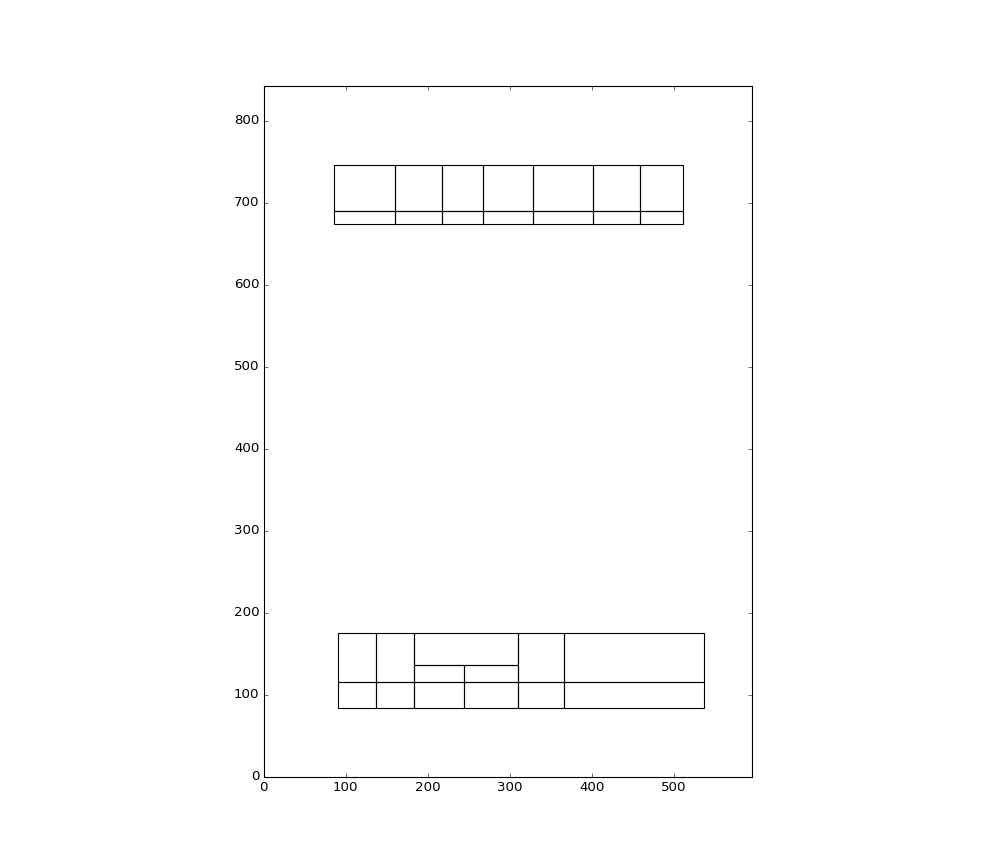

In [96]:
# Draw rectangles
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')  # 111: nrows, ncols, plot_number
ax1.set_xlim(layout.x0, layout.x1)
ax1.set_ylim(layout.y0, layout.y1)

for x0, y0, x1, y1 in lsRects:
    ax1.add_patch(
        patches.Rectangle(
            (x0, y0),   # (x,y)
            x1 - x0,          # width
            y1 - y0,          # height
            fill=bFill      # no background
        )
    )
#end for

plt.show()

<IPython.core.display.Javascript object>


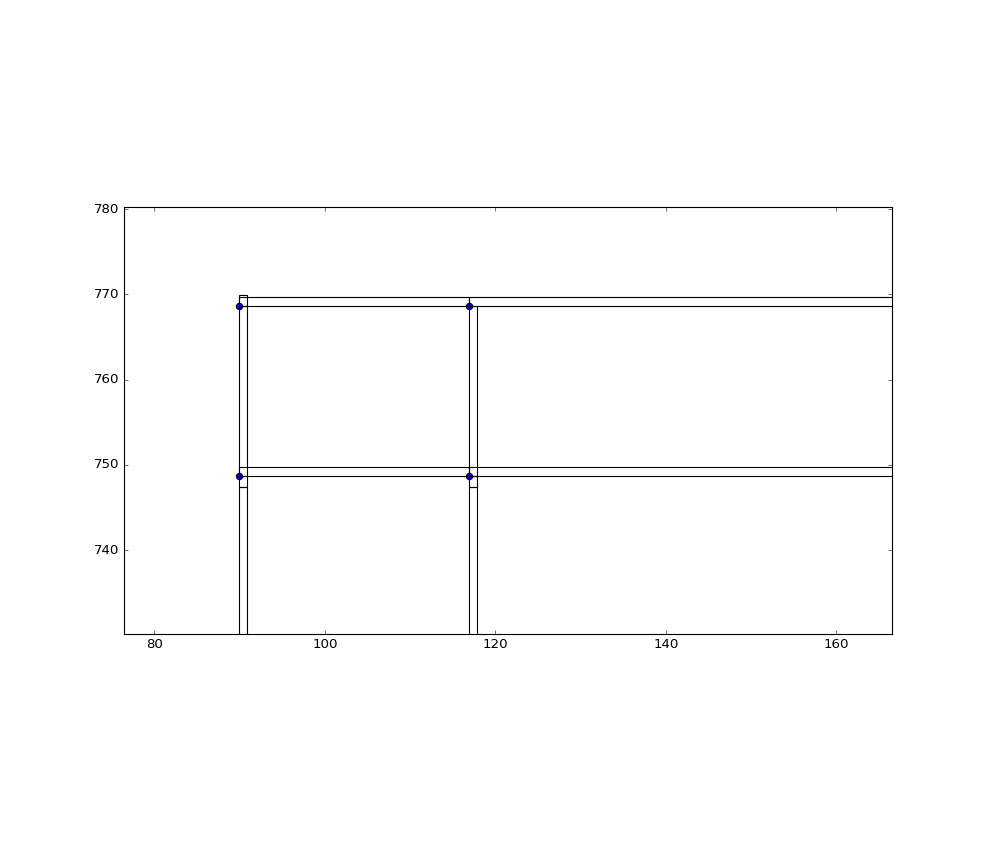

In [78]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')  # 111: nrows, ncols, plot_number
ax1.set_xlim(layout.x0, layout.x1)
ax1.set_ylim(layout.y0, layout.y1)

for x, y in dCornerInfo:
    ax1.scatter(x, y, s=32)

#'''
for x, lsY in dX.items():
    for y0, y1 in lsY:
        ax1.add_patch(
            patches.Rectangle(
                (x, y0),   # (x,y)
                1,          # width
                y1 - y0,          # height
                fill=bFill      # no background
            )
        )
#'''

#'''
for y, lsX in dY.items():
    for x0, x1 in lsX:
        ax1.add_patch(
            patches.Rectangle(
                (x0, y),   # (x,y)
                x1 - x0,          # width
                1,          # height
                fill=bFill      # no background
            )
        )
#'''

plt.show()

<IPython.core.display.Javascript object>


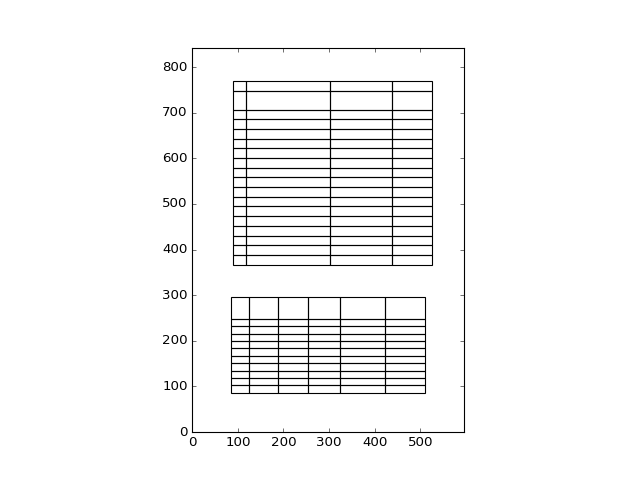


Total specified objects: 403
Number of corners: 179
Totally 138 cells
(90.38, 748.2, 116.89999999999999, 769.44)
(116.89999999999999, 748.2, 301.48, 769.44)
(301.48, 748.2, 436.98, 769.44)
(436.98, 748.2, 526.5, 769.44)
(90.38, 706.92, 116.89999999999999, 748.2)
(116.89999999999999, 706.92, 301.48, 748.2)
(301.48, 706.92, 436.98, 748.2)
(436.98, 706.92, 526.5, 748.2)
(90.38, 685.66, 116.89999999999999, 706.92)
(116.89999999999999, 685.66, 301.48, 706.92)
(301.48, 685.66, 436.98, 706.92)
(436.98, 685.66, 526.5, 706.92)
(90.38, 664.42, 116.89999999999999, 685.66)
(116.89999999999999, 664.42, 301.48, 685.66)
(301.48, 664.42, 436.98, 685.66)
(436.98, 664.42, 526.5, 685.66)
(90.38, 643.18, 116.89999999999999, 664.42)
(116.89999999999999, 643.18, 301.48, 664.42)
(301.48, 643.18, 436.98, 664.42)
(436.98, 643.18, 526.5, 664.42)
(90.38, 621.94, 116.89999999999999, 643.18)
(116.89999999999999, 621.94, 301.48, 643.18)
(301.48, 621.94, 436.98, 643.18)
(436.98, 621.94, 526.5, 643.18)
(90.38, 600.6

In [12]:
#'''
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')  # 111: nrows, ncols, plot_number
ax1.set_xlim(layout.x0, layout.x1)
ax1.set_ylim(layout.y0, layout.y1)
#''' 

i = 0
lsVLines = []
lsHLines = []
lsRects = []
for lt_obj in layout:
    #print(type(lt_obj))
    if isinstance(lt_obj, LTRect):
        if lt_obj.width < 1 and lt_obj.height < 1:
            continue
        i += 1
        #print(lt_obj.width, lt_obj.height)
        if lt_obj.width < 1:
            lsVLines.append(lt_obj)
        elif lt_obj.height < 1:
            lsHLines.append(lt_obj)
        else:
            lsRects.append(lt_obj)

#end for

print("\nTotal specified objects: {}".format(i))
# Sort by y (vertically), and then x. (Not too precisely)
slHLines = sorted(lsHLines, key = lambda obj: obj.y0 + obj.x0/layout.x1*2)
slVLines = sorted(lsVLines, key = lambda obj: obj.y0 + obj.x0/layout.x1*2)


dCorners = {}
for hLine in slHLines:
    #print(hLine.x0, hLine.y0)
    for vLine in slVLines:
        if vLine.x0 <= hLine.x0 - 1 or vLine.x0 >= hLine.x1 + 1:
            continue
        stCross = None
        # Intersect from below the horizontal line
        if vLine.y1 > hLine.y0 - 1 and vLine.y1 < hLine.y0 + 1:
            stCross = {'b'}           # below
        # Intersect from above the horizontal line
        elif vLine.y0 > hLine.y0 - 1 and vLine.y0 < hLine.y0 + 1:
            stCross = {'a'}           # above
        elif vLine.y0 >= hLine.y0 + 1:
            break    # Skip the following (because the lines are ordered by position).
        
        if stCross:
            if vLine.x0 > hLine.x0 - 1 and vLine.x0 < hLine.x0 + 1:
                tPoint = (hLine.x0, hLine.y0)
                stCross.add('r')      # right
            elif vLine.x0 > hLine.x1 - 1 and vLine.x0 < hLine.x1 + 1:
                tPoint = (hLine.x1, hLine.y0)
                stCross.add('l')      # left
            elif vLine.x0 > hLine.x0 - 1 and vLine.x0 < hLine.x1 + 1:
                tPoint = (vLine.x0, hLine.y0)
                stCross.add('l')      # left
                stCross.add('r')      # right
            
            tEntry = getPtEntry(dCorners, tPoint)
            dCorners[tEntry].update(stCross)

print("Number of corners: {}".format(len(dCorners)))

'''
for tPoint, stCross in dCorners.items():
    #plt.scatter(tPoint[0], tPoint[1])
    x, y = tPoint
    if 'a' in stCross:
        plt.plot((x, x), (y, y+5))
    if 'b' in stCross:
        plt.plot((x, x), (y, y-5))
    if 'l' in stCross:
        plt.plot((x, x-5), (y, y))
    if 'r' in stCross:
        plt.plot((x, x+5), (y, y))

plt.show()
#'''

# Generate the whole table (neighbor info for each point)
slCornersH = sorted(dCorners.items(), key = lambda t: t[0][1] + t[0][0]/layout.x1*2)
slCornersV = sorted(dCorners.items(), key = lambda t: t[0][0] + t[0][1]/layout.y1*2)
dTable = {}
for i in range(0, len(slCornersH)):
    tPoint, stCross = slCornersH[i]
    dNeighbor = {}
    if 'l' in stCross:
        dNeighbor['l'] = slCornersH[i-1][0]
    if 'r' in stCross:
        dNeighbor['r'] = slCornersH[i+1][0]
    dTable[tPoint] = dNeighbor
#end for
for i in range(0, len(slCornersV)):
    tPoint, stCross = slCornersV[i]
    dNeighbor = dTable[tPoint]
    if 'b' in stCross:
        dNeighbor['b'] = slCornersV[i-1][0]
    if 'a' in stCross:
        dNeighbor['a'] = slCornersV[i+1][0]
#end for

i = 0
for tPoint, dNeighbor in dTable.items():
    if ('r' in dNeighbor) and ('a' in dNeighbor):
        i += 1
        tUp = dNeighbor['a']
        while 'r' not in dTable[tUp]:
            tUp = dTable[tUp]['a']
        tUpRght = dTable[tUp]['r']
        tRect = (tPoint[0], tPoint[1], tUpRght[0], tUpRght[1])
        #print(tRect)
        lsRects.append(tRect)
        ax1.add_patch(
            patches.Rectangle(
                (tPoint[0], tPoint[1]),   # (x,y)
                tUpRght[0] - tPoint[0],          # width
                tUpRght[1] - tPoint[1],          # height
                fill=False      # no background
            )
        )


print("Totally {} cells".format(i))
plt.show()

slRects = sorted(lsRects, key = lambda t: -t[1]+t[0]/layout.x1)
for x in slRects:
    print(x)